# Imitation learning training script!!!!

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import numpy as np
import pathlib

import random
import time

import matplotlib.pyplot as plt

import cv2

## Check if CUDA is available

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Data loader

In [3]:
max_z = 5.0

In [4]:
# Load all sessions and combine into a single pool
base_path = pathlib.Path("/home/kazuh/Documents/UBC/ENPH_353/training_data/Sessions_with_noise")
session_dirs = sorted([d for d in base_path.iterdir() if d.is_dir()])

all_img_paths = []
all_z_vals = []

print("Loading data from all sessions...")
for session_dir in session_dirs:
    labels_path = session_dir / "labels.csv"
    df = pd.read_csv(labels_path, header=None, skiprows=1)
    
    for _, row in df.iterrows():
        img_path = session_dir / row[0]
        all_img_paths.append(img_path)
        all_z_vals.append(row[2] / max_z)

print(f"Total samples loaded: {len(all_img_paths)}")

# Convert to numpy arrays
all_z_vals = np.array(all_z_vals)

# Randomize the order
indices = np.arange(len(all_img_paths))
np.random.shuffle(indices)

all_img_paths = [all_img_paths[i] for i in indices]
all_z_vals = all_z_vals[indices]

# Split into train and validation sets (80/20 split)
split_idx = int(0.8 * len(all_img_paths))

train_img_paths = all_img_paths[:split_idx]
train_z_vals = all_z_vals[:split_idx]

val_img_paths = all_img_paths[split_idx:]
val_z_vals = all_z_vals[split_idx:]

print(f"Training samples: {len(train_img_paths)}")
print(f"Validation samples: {len(val_img_paths)}")

Loading data from all sessions...
Total samples loaded: 9650
Training samples: 7720
Validation samples: 1930


In [5]:
class DrivingDataset(torch.utils.data.Dataset):

    def __init__(self, img_paths, z_vals):
        self.img_paths = img_paths
        self.z_vals = z_vals

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = str(self.img_paths[idx])

        img = cv2.imread(img_path)
        if img is None:
            raise RuntimeError(f"Could not load image: {img_path}")

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (160, 120))
        img = img.astype(np.float32) / 255.0
        img = np.transpose(img, (2, 0, 1))  # (H,W,C)->(C,H,W)

        x = np.array([self.z_vals[idx]], dtype=np.float32)

        return torch.tensor(img), torch.tensor(x)


In [6]:
batch_size = 32

train_dataset = DrivingDataset(train_img_paths, train_z_vals)
val_dataset   = DrivingDataset(val_img_paths, val_z_vals)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True
)


## Design Model

In [7]:
class JackDrivingModel(nn.Module):

    def __init__(self, img_channels = 3, img_h = 120, img_w = 160, act_dim = 1):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(img_channels, 24, kernel_size=5, stride=2), nn.SiLU(),
            nn.Conv2d(24, 36, kernel_size=5, stride=2), nn.SiLU(),
            nn.Conv2d(36, 48, kernel_size=5, stride=2), nn.SiLU(),
            nn.Conv2d(48, 64, kernel_size=3, stride=1), nn.SiLU()
        )

        with torch.no_grad():
            dummy = torch.zeros(1, img_channels, img_h, img_w)
            conv_out = self.conv(dummy)
            conv_feat_dim = conv_out.view(1, -1).shape[1]

        self.fc = nn.Sequential(
            nn.Linear(conv_feat_dim, 32), nn.LeakyReLU(),
            nn.Linear(32, 16), nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, act_dim)  # [wz]
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

        

In [8]:
def reset_model_weights(model):
    """
    Reinitializes all model parameters by calling reset_parameters()
    for each layer that implements it (Conv, Linear, etc.).
    """
    for layer in model.modules():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()


## Training

In [ ]:
model = JackDrivingModel(img_channels=3, img_h=120, img_w=160, act_dim=1)
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
reset_model_weights(model)

In [10]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for imgs, targets in loader:
        imgs = imgs.to(device)
        targets = targets.to(device)

        # ---- zero gradients on optimizer ----
        optimizer.zero_grad()

        # ---- forward pass ----
        outputs = model(imgs)
        loss = criterion(outputs, targets)

        # ---- backward pass ----
        loss.backward()

        # ---- update weights ----
        optimizer.step()

        # accumulate weighted loss
        running_loss += loss.item() * imgs.size(0)

    # return epoch-averaged loss
    return running_loss / len(loader.dataset)



In [11]:
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for imgs, targets in loader:
            imgs = imgs.to(device)
            targets = targets.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * imgs.size(0)

    return running_loss / len(loader.dataset)


In [12]:
def train(epochs):
    train_history = []
    val_history = []

    for epoch in range(epochs):
        # ---- Training ----
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        train_history.append(train_loss)

        # ---- Validation ----
        val_loss = validate(model, val_loader, criterion, device)
        val_history.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # ---- Plot learning curves ----
    plt.figure(figsize=(10, 5))
    plt.plot(train_history, label="Train Loss")
    plt.plot(val_history, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    return train_history, val_history



Epoch 1/60 | Train Loss: 0.0895 | Val Loss: 0.0771
Epoch 2/60 | Train Loss: 0.0662 | Val Loss: 0.0619
Epoch 2/60 | Train Loss: 0.0662 | Val Loss: 0.0619
Epoch 3/60 | Train Loss: 0.0573 | Val Loss: 0.0526
Epoch 3/60 | Train Loss: 0.0573 | Val Loss: 0.0526
Epoch 4/60 | Train Loss: 0.0502 | Val Loss: 0.0502
Epoch 4/60 | Train Loss: 0.0502 | Val Loss: 0.0502
Epoch 5/60 | Train Loss: 0.0474 | Val Loss: 0.0465
Epoch 5/60 | Train Loss: 0.0474 | Val Loss: 0.0465
Epoch 6/60 | Train Loss: 0.0440 | Val Loss: 0.0468
Epoch 6/60 | Train Loss: 0.0440 | Val Loss: 0.0468
Epoch 7/60 | Train Loss: 0.0410 | Val Loss: 0.0436
Epoch 7/60 | Train Loss: 0.0410 | Val Loss: 0.0436
Epoch 8/60 | Train Loss: 0.0391 | Val Loss: 0.0447
Epoch 8/60 | Train Loss: 0.0391 | Val Loss: 0.0447
Epoch 9/60 | Train Loss: 0.0367 | Val Loss: 0.0466
Epoch 9/60 | Train Loss: 0.0367 | Val Loss: 0.0466
Epoch 10/60 | Train Loss: 0.0352 | Val Loss: 0.0435
Epoch 10/60 | Train Loss: 0.0352 | Val Loss: 0.0435
Epoch 11/60 | Train Loss: 0.0

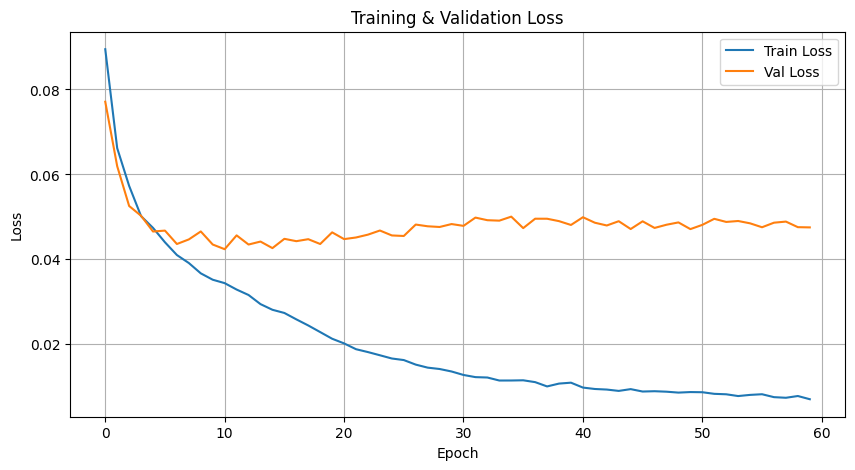

In [13]:
if __name__ == '__main__':
    train(60)
    torch.save(model.state_dict(), "last_model.pth")


# Convert to PT

In [ ]:
model_export = JackDrivingModel(img_channels=3, img_h=120, img_w=160, act_dim=1)

state = torch.load("/home/kazuh/Documents/UBC/ENPH_353/training_data/model_making/last_model.pth")
model_export.load_state_dict(state)

model_export.eval()
scripted_model = torch.jit.script(model_export)

scripted_model.save("12_2_1.pt")